# Flash calculations

Flash, or more general phase separation calculations is the process of determining the equilibrium state of a system under conditions specified by thermodynamic state functions.
At equilibrium the available mass splits into one or multiple physical states like liquid or gas.
To specify the thermodynamic state, three state quantities are required:

- mass of present components/ chemical species (mole numbers, overall compositions, ...)
- state function related to work energy (pressure or volume)
- state function related to thermal energy (temperature, internal energy, enthalpy)

PorePy provides some functionality to determine the equilibrium state of fluid mixtures.
It does **not** cover the full range of possible thermodynamic calculations and state definitions.
Instead it focuses on the properties and state definitions relevant for thermal compositional flow in the subsurface as indicated above.
One core ability of PorePy's flash framework is the ability to solve large amounts of flash calculations very efficiently,
making it suitable for cell-wise applications in flow simulations.

This tutorial explains the flash API and presents example calculations using a compiled persistent-variable flash.
A familiarity with the [tutorial on fluid modeling](./fluid_modeling.ipynb) and on [cubic equations of state](./cubic_eos.ipynb) is of advantage.

### Table of Contents

1. [Usage of numba](#usage-of-numba)
2. [General flash API](#general-flash-api)
3. [Example: Persistent-variable flash](#example-persistent-variable-flash)
4. [Flash solvers](#flash-solvers)
5. [Example: Semi-smooth Newton solver](#example-a-semi-smooth-newton-solver)
6. [Conclusion](#conclusion)

## Usage of numba

Available flash implementions in PorePy rely heavily in [numba](https://numba.pydata.org/).<br>
What you need to know as a user is that 

1. The framework relies on *eager* just-in-time compilation.
2. Compilation can be disabled for debugging or smaller problems.

The flash framework has certain levels of abstractions which would require some ahead-of-time compilation.
While this is not yet fully supported by numba, we achieve a similar effect with static signature typing, which forces compilation ahead of usage (eager JIT).<br>
*This leads to a certain overhead in execution time when importing the flash module for the first time, and when compiling the flash for a specific fluid.*<br>
It also requires an explicit compilation step before the flash calculations are available.

To disable compilation and just use the pure Python implementation, do the following:

In [1]:
import os
# os.environ["NUMBA_DISABLE_JIT"] = "1"

By uncommenting this flag, numba compilation is disabled and you will run the module with pure Python code.

The first thing you will notice is that it is significantly slower, but the calculations will start right away.
This is especially handy if you want to solve only a few problems to get an idea of how the mixture behaves, or you need some concrete values (try it!), or simply debug.

## General flash API

The flash is essentially the solution of a challenging system of nonlinear algebrai equations.
While the structure of the equations is always the same, individual terms depend on the present components, their physical parameters and the underlying equation of state.

Therefore, the flash is implemented as an object containing templates for those equations.
It populates them with the information provided by an instance of [Fluid](../src/porepy/compositional/base.py#706).

The generel flash is hence instantiated using some fluid object.

In [2]:
from inspect import getsource, signature

import porepy.compositional.flash as pf

print(signature(pf.AbstractFlash.__init__))

(self, fluid: 'pp.Fluid[pp.FluidComponent, pp.Phase]', params: 'Optional[dict]' = None) -> 'None'


Once the flash object is created, the interface for the flash is as follows:

In [3]:
print(getsource(pf.AbstractFlash.flash))

    @abc.abstractmethod
    def flash(
        self,
        specification: StateSpecType,
        z: Optional[Sequence[np.ndarray | pp.number]] = None,
        /,
        *,
        initial_state: Optional[pp.compositional.FluidProperties] = None,
        params: Optional[dict] = None,
        **kwargs,
    ) -> FlashResults:
        """Abstract method for performing a flash procedure.

        The equilibrium state must be defined in terms of compositions ``z`` and two
        state functions declared in ``specification``.
        One state must relate to pressure or volume. The other to energy.

        Parameters:
            specifications: Equilibrium specifications in terms of state functions.
            z: ``default=None``

                Overall fractions of mass per component.

                It is only optional for pure fluids (``z`` is implicitly assumed to be
                1). For fluid mixtures with multiple components it must be of length
                ``num_compo

The minimum we need are equilibrium `specifications` in terms of two state functions.
PorePy supports two types of state specifications:

- Isobaric specifications (pressure at equilibrium is given)
- Isochoric specifications (specific volume of the fluid at equilibrium is given)

In [4]:
print(getsource(pf.IsobaricSpecifications))

class IsobaricSpecifications(TypedDict):
    """Typed dictionary for isobaric equilibrium specifications.

    The pressure values are obligatory and one energy-related variable is required.

    """

    p: np.ndarray | pp.number
    """Pressure at equilibrium."""

    T: NotRequired[np.ndarray | pp.number]
    """Temperature at equilibrium."""

    h: NotRequired[np.ndarray | pp.number]
    """Specific fluid enthalpy at equilibrium."""



We see that isobaric specifications have two additional optional fields, temperature and specific fluid enthalpy.
One of them must be given additionally.
Providing pressure and enthalpy values invokes the ph-flash for example.

Additionally to the state functions, the mass must be provided in form of overall compositions `z` (fractions of total mass associated with a component in the fluid). <br>
If the fluid has only 1 component, this argument is not required and implicitly assumed to be one.

The `initial_state` argument can be used to provide an initial guess for the flash problem. Otherwise the flash object has to compute them. *Note that this is not a trivial task in thermodynamics and can contribute noticeably to the overall time spent to solve the problem*.

The return value is a [FlashResults](../src/porepy/compositional/flash/abstract_flash.py##116) data structure, which is an extension of [FluidProperties](../src/porepy/compositional/states.py#231).
Additionally to all fluid properties evaluated at equilibrium, it also contains some metrics of the performed flash, like convergence flags and number of iterations.
This structure can be used to feed values into a global flow system for example.

## Example: Persistent-variable flash

We first define the fluid components of interest. For more details on below code, please see the [tutorial on cubic eos](./cubic_eos.ipynb).

In [5]:
import numpy as np
import numba as nb
import porepy as pp
import porepy.compositional.peng_robinson as pr

h2o = pp.compositional.FluidComponent(
    name="H2O",
    acentric_factor=0.3443,
    critical_pressure=22064000.0,
    critical_specific_volume=5.59480372671e-05,
    critical_temperature=647.096,
    molar_mass=0.01801528,
)

co2 = pp.compositional.FluidComponent(
    name="CO2",
    acentric_factor=0.22394,
    critical_pressure=7377300.0,
    critical_specific_volume=9.41184770731e-05,
    critical_temperature=304.1282,
    molar_mass=0.04400950000000001,
)

h2s = pp.compositional.FluidComponent(
    name="H2S",
    acentric_factor=0.1005,
    critical_pressure=9000000.0,
    critical_specific_volume=9.81354268891e-05,
    critical_temperature=373.1,
    molar_mass=0.03408088,
)

components = [h2o, co2, h2s]

bips = np.array(
    [
        [0.0, 0.0952, 0.0394],
        [0.0952, 0.0, 0.0967],
        [0.0394, 0.0967, 0.0],
    ]
)

h_ideal = [pr.h_ideal_H2O, pr.h_ideal_CO2, pr.h_ideal_H2S]

C:\Users\vl-work\Desktop\github\porepy\src\porepy\compositional\peng_robinson\compressibility_factor.py:682: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  droots: np.ndarray = np.dot(


The persistent variable flash employs a persistent variable formulation of the phase separation problem.

Meaning, even if a phase is not present, it accounts for respective degrees of freedom and expects an extended representation of the underlying EoS.
It binds the mass from below by zero, and allows dissapeared phase fractions to take the value zero.

Two central limitations need to be mentioned:

1. So far it is only able to solve a 2-phase flash.
2. All phases must have the same underlying EoS object (which is not a limitation per se, but many practical applications do it otherwise)

In [6]:
import logging
import sys

from porepy.compositional.compiled_eos import (
    PROPERTY_FUNC_SIGNATURE,
    PROPERTY_DERIVATIVE_FUNC_SIGNATURE,
)


date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt=date_strftime_format,
)
logging.getLogger("porepy").setLevel(logging.DEBUG)


class PRLBC(pr.CompiledPengRobinson, pr.LBCViscosity):
    """Combined Peng-Robinson EoS and LBC viscosity model, for demonstration purposes.

    Thermal conductivities are set to 1.0, with zero derivatives.

    """

    def get_conductivity_function(self):
        @nb.njit(PROPERTY_FUNC_SIGNATURE)
        def kappa_c(prearg: np.ndarray, p: float, T: float, xn: np.ndarray) -> float:
            return 1.0

        return kappa_c

    def get_conductivity_derivative_function(self):
        @nb.njit(PROPERTY_DERIVATIVE_FUNC_SIGNATURE)
        def dkappa_c(
            prearg_val: np.ndarray,
            prearg_jac: np.ndarray,
            p: float,
            T: float,
            xn: np.ndarray,
        ) -> np.ndarray:
            return np.zeros(2 + xn.shape[0], dtype=np.float64)

        return dkappa_c


components1 = components[:2]
eos1 = PRLBC(
    components1, ideal_enthalpies=h_ideal[:2], bip_matrix=bips[:2, :2]
)
phases1 = [
    pp.compositional.Phase(pp.compositional.PhysicalState.liquid, "L", eos1),
    pp.compositional.Phase(pp.compositional.PhysicalState.gas, "G", eos1),
]
phases1[0].components = components1
phases1[1].components = components1
fluid1 = pp.compositional.Fluid(components1, phases1)

flash1 = pf.CompiledPersistentVariableFlash(fluid1)

flash1.compile(pf.FlashSpec.pT, pf.FlashSpec.ph)
logging.getLogger("porepy").setLevel(logging.INFO)

2025-11-25 16:54:18 Compiling symbolic Peng-Robinson EoS ..
2025-11-25 16:54:18 Compiling symbolic functions 1/12
2025-11-25 16:54:18 Compiling symbolic functions 2/12
2025-11-25 16:54:18 Compiling symbolic functions 3/12
2025-11-25 16:54:19 Compiling symbolic functions 4/12
2025-11-25 16:54:20 Compiling symbolic functions 5/12
2025-11-25 16:54:27 Compiling symbolic functions 6/12
2025-11-25 16:54:28 Compiling symbolic functions 7/12
2025-11-25 16:54:28 Compiling symbolic functions 8/12
2025-11-25 16:54:30 Compiling symbolic functions 9/12
2025-11-25 16:54:30 Compiling symbolic functions 10/12
2025-11-25 16:54:31 Compiling symbolic functions 11/12
2025-11-25 16:54:31 Compiling symbolic functions 12/12
2025-11-25 16:54:31 Compiling property functions ..
2025-11-25 16:54:31 Compiling property functions 1/14
2025-11-25 16:54:33 Compiling property functions 2/14
2025-11-25 16:54:33 Compiling property functions 3/14
2025-11-25 16:54:33 Compiling property functions 4/14
2025-11-25 16:54:34 C

The flash compilation takes roughly 40 seconds. Half of it is spent on compiling the EoS, and roughly 10% on compiling initial guess routines.
Individual parts can be compiled by accessing the respective object directly. It is important though to compile the EoS before anything else.
The flash object is smart enough to compile only what it needs and what is requested, and to avoid re-compilation.

If the mixture is changed in terms of components, phases or parameters, it must any case be created from scratch, as well as the flash, and compiled.

Let us now use the flash to compute some results.
The base interface is as follows:

In [7]:
p = 1e7  # Pa
T = 400.0  # K
z = np.array([0.9, 0.1])  # overall molar fractions, in the order of components

params = {
    "solver": "npipm",
    "mode": "sequential",
    'gen_arg_params': [0.2],
    'phase_property_params': [0.0],
    'solver_params': {
        'max_iterations': 150,
        'tolerance': 1e-5,
        'npipm_u2': 10.,
        'armijo_rho': 0.99,
    },
}

results = flash1.flash(
    {"p": p, "T": T},
    z,
    params=params,
)

2025-11-25 16:54:54 1 pT flash solved (elapsed time: 0.00117 (s)).


We use isobaric state specifications and provide overall composition values since it is a 2-component fluid.

All entries in `params` are optional, i.e., they have default values. We demonstrate some of the possibilities here and explain:

1. `'solver'` defines which solver to use. The current default is a Non-Parametric Interior Point Method, which is also the only solver currently availabe. You can find it [here](../src/porepy/compositional/flash/solvers/npipm_solver.py).
2. `'solver_params'` can be provided to override the default solver parametrization, in case some fine tuning is necessary. There are [general solver parameters](../src/porepy/compositional/flash/solvers/_core.py#40) and solver-specific parameters (for [npipm see here](../src/porepy/compositional/flash/solvers/npipm_solver.py#38)). Note that the NPIPM consists of several methods, including a line search. I.e., respective parameters are included. Parameters belonging to a specific method are usually indicated with `<methodname>_` as a prefix.
3. The `'mode'` defines how the flash problems are solved, sequentially or in parallel. Since we solve only 1 problem, we use the sequential solver (which is the default case). This framework parallelizes over the available CPU cores.
4. `'gen_arg_params'` and `'phase_property_params'` are essentially the same but passed at different times of the procedure. `'gen_arg_params'` is used in the solver, supporting convergence, while `'phase_property_params'` is used for the final evaluation of fluid properties after the solver exits. For how the `gen_arg_params` are used, see next section on generic flash argument. For how the `phase_property_params` are used, see the [general property computations](../src/porepy/compositional/compiled_eos.py#1008) of the EoS class.

The [FlashResult](../src/porepy/compositional/flash/abstract_flash.py#116) is an extended [FluidProperty](../src/porepy/compositional/states.py#231) with additional information regarding the flash procedure. Some examples are below:

In [8]:
print(results.converged)
print(results.num_iter)
print(results.sat, results.sat.shape)
print(results.p, results.T, results.z)

[ True]
[2]
[[0.44009303]
 [0.55990697]] (2, 1)
[10000000.] [400.] [[0.9]
 [0.1]]


We see that the flash converged and that it required 4 iterations. The result is a two-phase mixture with 55% gas.
We also see that the intensive state $p,T,z$ of the results structure is the same as the target state we defined when calling the flash.
And most importantly, we see that the result structure always returns the results in vectorized form. I.e., the saturations are an array with shape `(2,1)`, each row corresponding to a phase in `phases1`, and each column corresponding to a equilibrium specification.

Let's run a self-consistency check for the isenthalpic flash. I.e., using the enthalpy value of the above results, the ph-flash should return roughly 400 K as the temperature.

In [9]:
params['solver_params']['tolerance'] = 1e-7
params['solver_params']['armijo_max_iterations'] = 30
results_ph = flash1.flash(
    {"p": p, "h": results.h},
    z,
    params=params,
)

print('Original T:', results.T)
print('PH flash T:', results_ph.T)
print('Difference:', np.abs(results.T - results_ph.T))
print('Original h:', results.h)
print('PH flash h:', results_ph.h)
print('Difference:', np.abs(results.h - results_ph.h))

2025-11-25 16:54:54 1 ph flash solved (elapsed time: 0.00146 (s)).
Original T: [400.]
PH flash T: [399.9999984]
Difference: [1.59665069e-06]
Original h: [-32304.1057839]
PH flash h: [-32304.10624227]
Difference: [0.00045836]


The ph flash comes close to the original temperature by a fraction of a mili-Kelvin, which we can consider okay.
Notice however, that this time the state definition in terms of enthalpy is not identical to the one returned in `results_ph`.
This is due to extensive thermodynamic properties like enthalpy **always being** evaluated using the intensive properties like pressure, temperature and fractions returned by the flash procedure. We recovered the temperature up to a precision of order `1e-4`, and this error propagates to the resulting fluid enthalpy being 0.03 J/mol different. By reducing the solver tolerance, that difference will be larger (try it!).

Let us now run a larger amount of flash problems and compare the sequential and parallelized execution.

In [10]:
import time, multiprocessing

N = 100000
p = np.linspace(1e7, h2o.critical_pressure - 1e6, N)
T = np.linspace(450., h2o.critical_temperature - 10., N)

params['solver_params']['armijo_max_iterations'] = 50
params['mode'] = 'sequential'
start_seq = time.time()
results_seq = flash1.flash(
    {"p": p, "T": T},
    z,
    params=params,
)
time_seq = time.time() - start_seq

params['mode'] = 'parallel'
start_par = time.time()
results_par = flash1.flash(
    {"p": p, "T": T},
    z,
    params=params,
)
time_par = time.time() - start_par

print(f"Sequential time: {time_seq:.4f} s")
print(f"Parallel time: {time_par:.4f} s")
print(f"Speed-up: {time_seq / time_par:.2f}x")
print('Number of CPU cores:', multiprocessing.cpu_count())

2025-11-25 16:55:35 100000 pT flash solved (elapsed time: 40.58821 (s)).
2025-11-25 16:55:56 100000 pT flash solved (elapsed time: 19.55318 (s)).
Sequential time: 41.4453 s
Parallel time: 20.4305 s
Speed-up: 2.03x
Number of CPU cores: 16


In the optimal case we expect a speed-up roughly on the order of the number of CPU cores.
But this is often not the case, depending on the remaining workload handled by the operating system.
Additionally, numba is (despite seeming low-level) a very high-level interface for parallelism.
We take what we can get out of it.

> Important:
>    As of now, numba does not support ``try.. except`` in the parallel environment.
>    This makes parallel execution fragile to exceptions thrown by the solver.
>    If an exception is thrown, the whole parallel execution is aborted.

Finally, let's investigate some utility functionality of the flash class.
We can plot phase diagrams easily using the following function:

2025-11-25 16:56:09 10000 pT flash solved (elapsed time: 12.43207 (s)).


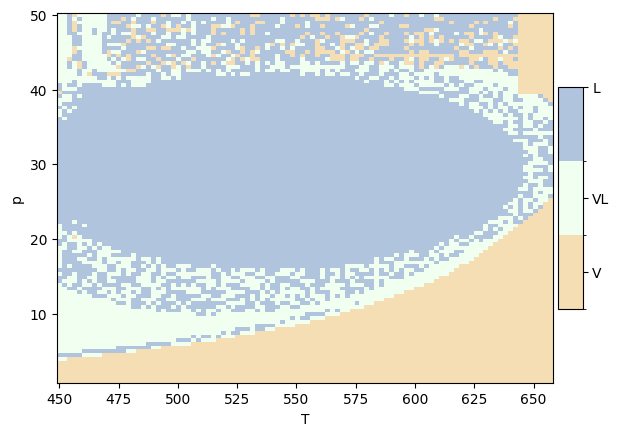

In [11]:
N = 100
p = np.linspace(1e6, 50e6, N)
T = np.linspace(450., h2o.critical_temperature + 10., N)
fig = flash1.plot_phase_diagram(
    pf.FlashSpec.pT,
    p,
    T,
    [0.99, 0.01],
    field='phasesplit',
    params=params,
    ytransform=lambda y: y / 1e6,  # Convert Pa to MPa
)


We can also use the mixture to plot the ph-diagram for almost pure water, and investigate the temperature profile.

In [ ]:
N = 100
p = np.linspace(1e6, 50e6, N)
h = np.linspace(-2.5e4, 6e3, N)
params['solver_params']['armijo_max_iterations'] = 30
params['solver_params']['npipm_u2'] = 1
fig = flash1.plot_phase_diagram(
    pf.FlashSpec.ph,
    p,
    h,
    [0.999, 0.001],
    field='T',
    params=params,
    ytransform=lambda y: y / 1e6,  # Convert Pa to MPa
)

2025-11-25 16:56:23 10000 ph flash solved (elapsed time: 13.99227 (s)).


SystemError: <function _numba_unpickle at 0x000001BA62D202C0> returned a result with an exception set

## Flash solvers

Flash solvers constitute an own group of functionality in `porepy.compositional.flash.solvers`.

In short, we can say the following:

1. They must be numba-compiled functions, or shallow wrappers for C-functions (`cfunc`).
2. They solve a nonlinear set of equations represented by a function `f(x)` which takes and returns a numpy array.
3. They have a specified signature for compatibility with the remaining framework.

The package provides a signature object which can be used for compilation.
If `numba.njit` succeeds in compiling the solver with this signature object, all is good.

In [ ]:
print('args:')
for i, a in enumerate(pf.SOLVER_FUNCTION_SIGNATURE.args):
    print(f'  {i}: {a}')
print('return type:')
print(pf.SOLVER_FUNCTION_SIGNATURE.return_type)

A flash solver takes the following arguments:

0. An initial guess `X0`.
1. A function representing the residual of the nonlinear equations `f(x)`.
2. A function representing the Jacobian of `f`.
3. A parameter dictionary with `str`-`float` pairs, containing any parameters the solver might need.
4. The Flash specification using `porepy.compositional.flash.FlashSpec`.

It returns:

0. The solution `X_n` satisfying `f(X_n) == 0`.
1. An exit code.
2. The number of performed iterations.

The following exit codes are reserved:

- 0: Converged
- 1: Maximal number of iterations reached
- 2: Divergence (`nan` or `infty` detected)
- 3: Failure in evaluating `f`
- 4: Failure in evaluating Jacobian of `f`
- 5: Any other failure.

This and more information, developers can find in the core module `porepy.compositional.flash.solvers._core`.

This signature enables us to easily parallelize, or execute sequentially, large quantities of flash problems.
The so-called multi-solvers are like base solvers, with the exception that they take the solver itself to be applied to individual problems.
They are bundled in the solver package as follows.

In [ ]:
from porepy.compositional.flash.solvers._core import _multi_solver_signature

for k, v in pf.MULTI_SOLVERS.items():
    print(f'Solver key: {k}')
    print(f'Solver function: {v}')

print('args:')
for i, a in enumerate(_multi_solver_signature.args):
    print(f'  {i}: {a}')
print('return type:')
print(_multi_solver_signature.return_type)


We see that the arguments and return values of the multi-solvers are analogous to the base solvers, with the exception that they take additionally the base solver as the fourth (3.) argument

### Generic Flash Arguments

Flash systems are, as mentioned above, represented by functions `f(x)` to simplify the solver interface.
In reality, flash systems require also the state functions which are not degrees of freedom as arguments, and potentially some parameters.

All that is formalized in something called *generic flash argument*.
Essentially, it is a pattern to put state specifications, parameters and actual degrees of freedom into a 1D array, which is readable by `f` and its Jacobian.

There is a whole module concerned with the assembly and the parsing of this generic flash arguments.
If you develop a solver or a flash for a new flash specification, you have to familiarize yourself with them in [flash_equations.py](../src/porepy/compositional/flash/flash_equations.py)

## Example: A semi-smooth Newton solver

In this section we build a new type of flash solver and demonstrate how to register it with the framework, and subsequently use it.

The solver built here is a semi-smooth Newton solver, which uses the `min` function for the complementarity conditions.

There are some things we need to know before attempting to do that:

1. The structure of any flash residual function is such that the last `num_phases` entries are the complementarity conditions per phase.
2. The Jacobians are such that the columns always correspond to a specific degree of freedom. The last `num_phase * num_components` entries are for the partial fractions. The `num_phase - 1` entries before them are for the independent phase fractions.
3. DOFs of the first phase (phase fraction and saturation) are always eliminated by unity of fractions.
4. The `compositional` package provides some interface to numba to avoid spurious errors when switching between compiled and non-compiled mode. We don't use `numba.njit` but a shallow wrapper `njit` found in the `_core` module.

In [ ]:
import numpy as np
from typing import Callable

from porepy.compositional._core import njit


@njit(pf.SOLVER_FUNCTION_SIGNATURE)
def semismooth_newton(
    X0: np.ndarray,
    F: Callable[[np.ndarray], np.ndarray],
    DF: Callable[[np.ndarray], np.ndarray],
    params: dict,
    spec: pf.FlashSpec,
) -> tuple[np.ndarray, int, int]:
    # Parsing solver parameters which are always passed by the PersistentVariableFlash.
    ncomp = int(params["num_components"])
    nphase = int(params["num_phases"])
    f_dim = int(params["f_dim"])
    tol = float(params["tolerance"])
    max_iter = int(params["max_iterations"])

    # Default return values: no convergence.
    num_iter = 0
    exitcode = 1

    # Creating update vector.
    X = X0.copy()
    DX = np.zeros_like(X0)

    # NOTE: This can of course be done more efficiently without assembling the
    # smooth complementarity conditions and their Jacobian fully.
    def F_ss(_X: np.ndarray) -> np.ndarray:
        F_val = F(_X)
        gen = pf.parse_generic_arg(_X, ncomp, nphase, spec)
        # Parsing partial fractions and phase fractions.
        x = gen[1]
        y = gen[2]
        unity = 1.0 - x.sum(axis=1)

        # Last nphase entries are always the complementarity conditions.
        for j in range(nphase):
            if y[j] <= unity[j]:
                F_val[-nphase + j] = y[j]
            else:
                F_val[-nphase + j] = unity[j]

        return F_val

    def DF_ss(_X: np.ndarray) -> np.ndarray:
        DF_val = DF(_X)
        gen = pf.parse_generic_arg(_X, ncomp, nphase, spec)
        # Parsing partial fractions and phase fractions.
        x = gen[1]
        y = gen[2]
        unity = 1.0 - x.sum(axis=1)
        npnc = ncomp * nphase

        # New block to be inserted into the Jacobian for the complementarity conditions.
        new_block = np.zeros((nphase, DF_val.shape[1]))
        for j in range(nphase):
            if y[j] <= unity[j]:
                new_block[1:, -(npnc + nphase - 1) : -npnc] = np.eye(nphase - 1)
                # First phase is always eliminated by unity.
                new_block[0, -(npnc + nphase - 1) : -npnc] = -1.0
            else:
                new_block[j, -(npnc + j * ncomp) : -(npnc + (j + 1) * ncomp)] = -1.0

        DF_val[-nphase:, :] = new_block
        return DF_val

    try:
        f_i = F_ss(X)
    except Exception:  # Faulty residual assembly.
        return X, 3, num_iter

    res_i = np.linalg.norm(f_i)

    if res_i <= tol:
        exitcode = 0  # root already found
    else:
        for _ in range(max_iter):
            num_iter += 1

            # Divergence check.
            if (
                np.any(np.isnan(f_i))
                or np.any(np.isinf(f_i))
            ):
                exitcode = 2
                break

            try:
                df_i = DF_ss(X)
            except Exception:  # Faulty Jacobian assembly.
                exitcode = 4
                break

            try:
                DX[-f_dim:] = np.linalg.solve(df_i, -f_i)
            except Exception:  # Failure in linear solver.
                exitcode = 5
                break

            # Divergence check.
            if np.any(np.isnan(DX)) or np.any(np.isinf(DX)):
                exitcode = 2
                break

            X = X + DX

            try:
                f_i = F_ss(X)
            except Exception:
                exitcode = 3
                break

            # Convergence check.
            res_i = np.linalg.norm(f_i)
            if res_i <= tol:
                exitcode = 0
                break

    return X, exitcode, num_iter

We now have a new solver which we want to use.
We register it by adding it to the solver framework.

In [ ]:
pf.SOLVERS['semismooth_newton'] = semismooth_newton

Now let's attempt to solve one of the previous problems with the new solver and let's see how it performs.

In [ ]:
results1: pf.FlashResults = ...

results_semismooth = flash1.flash(
    {
        'p': ...,
        'h': ...,
    },
    [0.99, 0.01],
    params={
        "solver": "semismooth_newton",
        "mode": "parallel",
    },
)

print(results1.converged.sum())
print(results_semismooth.converged.sum())

As expected, the default solver which uses an interior-point approach (and a couple of other tricks) performs overall better then a simple semi-smooth Newton.

## Conclusion